In [ ]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

In [1]:
from google.colab import files

files.upload()

In [ ]:
# 데이터 입력 
import openpyxl
filename = "상명대_전력수요예측_지수평활.xlsx" 
book = openpyxl.load_workbook(filename) #엑셀파일 book 변수에 저장
sheet=book.worksheets[0] #첫번쨰 워크시트 저장

In [ ]:
 data = []
 for row in sheet.rows: #전체 행에대하여 반복 실행
   data.append([
              row[0].value, #1열 데이터
              row[1].value, #2열 데이터
              row[2].value, #3열 데이터
              row[3].value, #4열 데이터
              row[4].value, #5열 데이터
              row[5].value  #6열 데이터
              ])

In [ ]:
import math
import pandas as pd
import numpy as np
data=pd.DataFrame(data[3:])
data.columns=["Name","No","Date","Time","P.D","Temp"]
data

,Name,No,Date,Time,P.D,Temp
0,신정,8,2018-01-01,1,6151.290,-3.2
1,신정,8,2018-01-01,2,6035.190,-3.3
2,신정,8,2018-01-01,3,6000.090,-3.7
3,신정,8,2018-01-01,4,5970.930,-4.0
4,신정,8,2018-01-01,5,6025.200,-4.2
...,...,...,...,...,...,...
8755,0,1,2018-12-31,20,7457.955,-3.7
8756,0,1,2018-12-31,21,7005.975,-4.6
8757,0,1,2018-12-31,22,6709.110,-5.4
8758,0,1,2018-12-31,23,6332.730,-5.2


#**전력만 사용**

In [ ]:
data=data["P.D"].values
data

array([6151.29, 6035.19, 6000.09, ..., 6709.11, 6332.73, 6096.75])

In [ ]:
# split a univariate dataset into train/test sets
# def train_test_split(data):
#   train=int(len(data)*0.6) #train
#   return data[:-train],data[-train:]

def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]  #train=8748, test=12

In [ ]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):  #n_in 갯수 만큼 데이터 묶기,data=train데이터 8748
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)  #가로로 합치기 
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

In [ ]:
# series_to_supervised(data,12,1)[0]  #input 12개, 예측 1개

array([6151.29 , 6035.19 , 6000.09 , 5970.93 , 6025.2  , 6570.195,
       6987.48 , 7198.08 , 7340.235, 7127.475, 7162.575, 7122.75 ,
       7093.32 ])

In [ ]:
# #데이터 12개
# series_to_supervised(data,12,1)[:,:-1]

array([[ 6151.29 ,  6035.19 ,  6000.09 , ...,  7127.475,  7162.575,
         7122.75 ],
       [ 6035.19 ,  6000.09 ,  5970.93 , ...,  7162.575,  7122.75 ,
         7093.32 ],
       [ 6000.09 ,  5970.93 ,  6025.2  , ...,  7122.75 ,  7093.32 ,
         7219.005],
       ...,
       [11294.925, 11152.095, 10270.95 , ...,  7943.82 ,  7457.955,
         7005.975],
       [11152.095, 10270.95 ,  9950.595, ...,  7457.955,  7005.975,
         6709.11 ],
       [10270.95 ,  9950.595, 10754.115, ...,  7005.975,  6709.11 ,
         6332.73 ]])

In [ ]:
# #예측값
# series_to_supervised(data,12,1)[:,-1]

array([7093.32 , 7219.005, 7321.065, ..., 6709.11 , 6332.73 , 6096.75 ])

In [ ]:
# root mean squared error or rmse
# 평균 제곱근 오차
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [ ]:
# fit a model
def model_fit(train, config):  #train=8748
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config  #config = [1, 12, 64, 3, 200, 350, 100]
	n_input = n_seq * n_steps

	# prepare data
	data = series_to_supervised(train, n_input,1)
	train_x, train_y = data[:, :-1], data[:, -1]  #train중, data[:, :-1]=마지막값 제외, data[:, -1]=마지막값
	train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))  #(8748,1,12,1)
 
	# define model
	model = Sequential()
 #TimeDistributed= 각 스텝마다 cost(오류)를 계산해서 하위 스텝으로 오류를 전파하여 각 weight를 업데이트하라는 의미
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(None,n_steps,1))))
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
#	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
	model.add(TimeDistributed(MaxPooling1D()))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=1)
	return model

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config):  #history=train
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
	# forecast
	yhat = model.predict(x_input, verbose=1)
	return yhat[0]

In [ ]:
import matplotlib.pyplot as plt
def draw_graph(test,predictions):
	fig = plt.figure(figsize=(10, 5))
	ax1 = fig.add_subplot(1, 1, 1)
	ax1.plot(test, 'b', label='Original')
	ax1.plot(predictions, 'r', label='Prediction')
	ax1.legend(loc="lower right")

In [ ]:
# walk-forward validation for univariate(단변량=종속변수 한개) data

#학습 및 에러계산
def walk_forward_validation(data, n_test, cfg):   #n_test=12
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)  #train=8748, test=12
	# fit model
	model = model_fit(train, cfg)
 
	# seed history with training dataset
	history = [x for x in train] 

	# step over each time-step in the test set
	for i in range(len(test)):
		yhat = model_predict(model, history, cfg)
		# store forecast in list of, 예측값모음=predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
  
	# estimate prediction errorrint("pre") 에러율 계산 
	error = measure_rmse(test, predictions)  
	print(' > %.3f' % error)
	draw_graph(test,predictions)
	print(test)
	print(predictions)
	return error

In [ ]:
# repeat evaluation of a config
#전체 에러 계산 
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]  #error 저장
	return scores

In [ ]:
# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
88/88 [==============================] - 1s 16ms/step - loss: 236584.9006
Epoch 8/350
88/88 [==============================] - 1s 16ms/step - loss: 229648.6445
Epoch 9/350
88/88 [==============================] - 1s 17ms/step - loss: 168427.9073
Epoch 10/350
88/88 [==============================] - 1s 16ms/step - loss: 160320.9034
Epoch 11/350
88/88 [==============================] - 1s 16ms/step - loss: 173640.6921
Epoch 12/350
88/88 [==============================] - 1s 16ms/step - loss: 151048.1950
Epoch 13/350
88/88 [==============================] - 1s 16ms/step - loss: 147685.6282
Epoch 14/350
88/88 [==============================] - 1s 17ms/step - loss: 158273.6392
Epoch 15/350
88/88 [==============================] - 1s 17ms/step - loss: 148283.9893
Epoch 16/350
88/88 [==============================] - 1s 16ms/step - loss: 191310.4867
Epoch 17/350
88/88 [==============================] - 1s 16ms/step - loss: 191039.5014
Epoch 18/350
88/88 [==

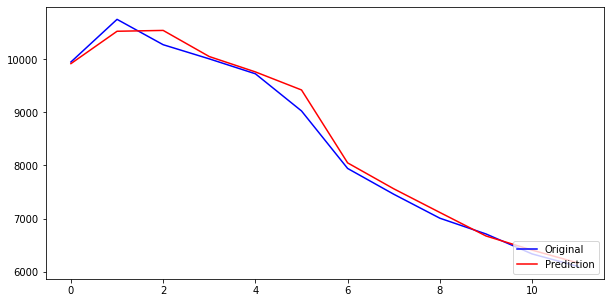

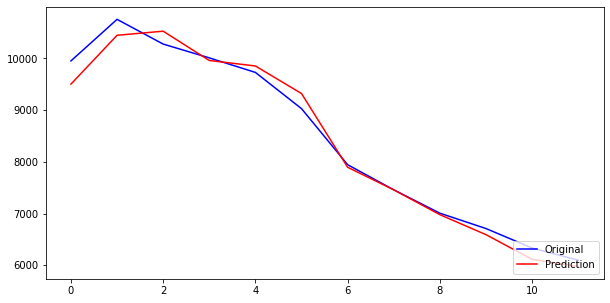

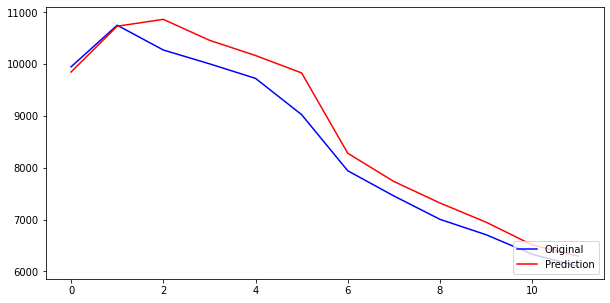

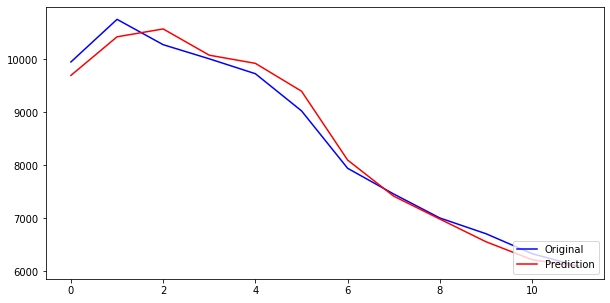

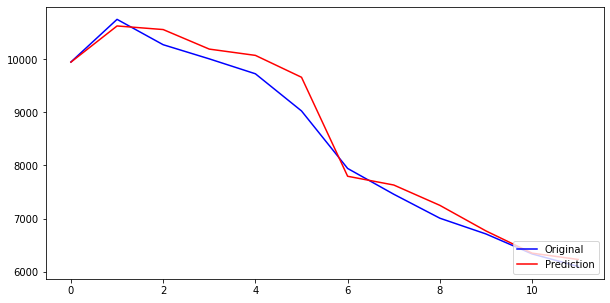

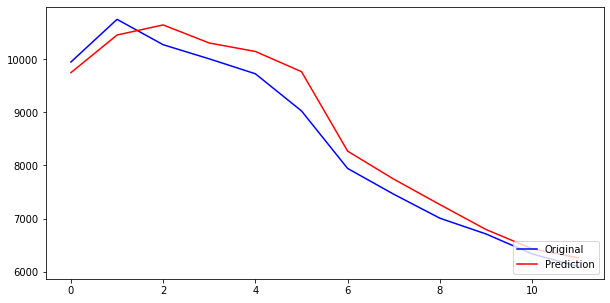

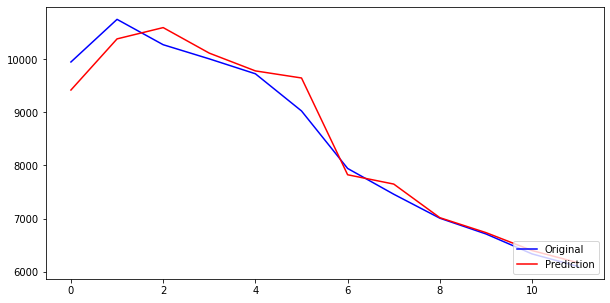

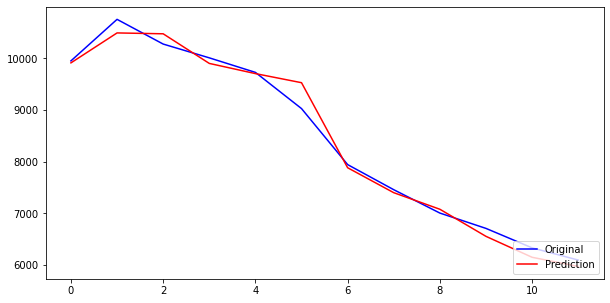

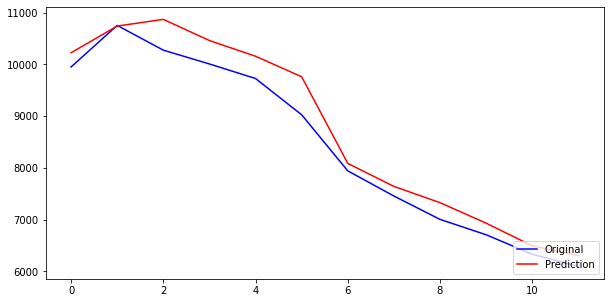

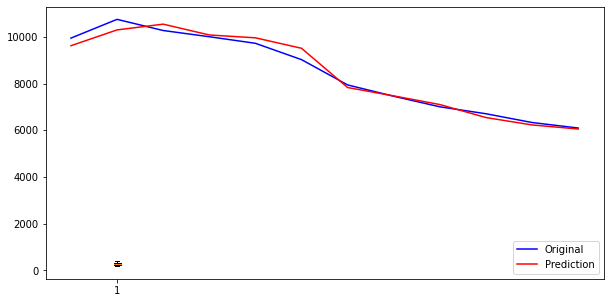

In [ ]:
# data split
n_test = 12

# define config 
# n seq: The number of subsequences within a sample.
# n steps: The number of time steps within each subsequence.
# n filters: The number of parallel filters.
# n kernel: The number of time steps considered in each read of the input sequence.
# n nodes: The number of LSTM units to use in the hidden layer.
# n epochs: The number of times to expose the model to the whole training dataset.
# n batch: The number of samples within an epoch after which the weights are updated.

config = [1, 12, 64, 3, 200, 350, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

# **전력+온도**

In [ ]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

In [2]:
from google.colab import files

files.upload()

In [ ]:
# 데이터 입력 
import openpyxl
filename = "상명대_전력수요예측_지수평활.xlsx" 
book = openpyxl.load_workbook(filename) #엑셀파일 book 변수에 저장
sheet=book.worksheets[0] #첫번째 워크시트 저장

In [ ]:
 data2 = []
 for row in sheet.rows: #전체 행에대하여 반복 실행
   data2.append([
              row[0].value, #1열 데이터
              row[1].value, #2열 데이터
              row[2].value, #3열 데이터
              row[3].value, #4열 데이터
              row[4].value, #5열 데이터
              row[5].value  #6열 데이터
              ])

In [ ]:
import math
import pandas as pd
import numpy as np
data2=pd.DataFrame(data2[3:])
data2.columns=["Name","No","Date","Time","P.D","Temp"]
data2

,Name,No,Date,Time,P.D,Temp
0,신정,8,2018-01-01,1,6151.290,-3.2
1,신정,8,2018-01-01,2,6035.190,-3.3
2,신정,8,2018-01-01,3,6000.090,-3.7
3,신정,8,2018-01-01,4,5970.930,-4.0
4,신정,8,2018-01-01,5,6025.200,-4.2
...,...,...,...,...,...,...
8755,0,1,2018-12-31,20,7457.955,-3.7
8756,0,1,2018-12-31,21,7005.975,-4.6
8757,0,1,2018-12-31,22,6709.110,-5.4
8758,0,1,2018-12-31,23,6332.730,-5.2


In [ ]:
columns = ['P.D', 'Temp']
data2 = data2[columns]
# data2=np.array(data2)
data2

,P.D,Temp
0,6151.290,-3.2
1,6035.190,-3.3
2,6000.090,-3.7
3,5970.930,-4.0
4,6025.200,-4.2
...,...,...
8755,7457.955,-3.7
8756,7005.975,-4.6
8757,6709.110,-5.4
8758,6332.730,-5.2


In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data2, n_test):
	return data2[:-n_test], data2[-n_test:]

In [ ]:
# transform list into supervised learning format
def series_to_supervised(m_data, n_in, n_out=1):
	m_data.dropna(inplace=True)
	train_series = [] # [ 
                      #   [[111, -1], [112, -2]], 
                      #   [[112, -2], [113, -3]], 
                      #   ...
                      # ]
	target_series = [] # [113, ...]
    # ---- Change these code for target values ----
    # Ex) [[111, -1], [112, -2], [113, -3]] -> [[111, -1], [112, -2]], [113]
    # 12개씩
	for i in range(0, n_in-1):
		row = [] # row represents a train series, in this case, [[111, -1], [112, -2]]
		count = i # count is the variable to access the target value, in this case, 113
		for j in range(12):
        # a row = [111, -1]
			row.append([value for value in m_data.loc[i+j].values])
			count += 1
		train_series.append(row)
		target_series.append(m_data.loc[count].values[0])
    # ----
	train_series = np.array(train_series, dtype="float32")
	target_series = np.array(target_series, dtype="float32")
	return train_series, target_series

In [ ]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [ ]:
# fit a model
def model_fit(train, config):
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
	n_input = n_seq * n_steps
	# prepare series_train
	series_train_x, series_train_y = series_to_supervised(train, 12, 1)
	series_train_x = series_train_x.reshape((series_train_x.shape[0], n_seq, n_steps, 2))
	# define model
	model = Sequential()
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(None,n_steps))))
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
#	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
	model.add(TimeDistributed(MaxPooling1D()))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(series_train_x, series_train_y, epochs=n_epochs, batch_size=n_batch, verbose=1) #verbose 0=silent,1=process bar, 2=one line per epoch
	return model

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config): #history=train
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps,2))

	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

In [ ]:
import matplotlib.pyplot as plt
def draw_graph(test,predictions):
  fig = plt.figure(figsize=(10, 5))
  ax1 = fig.add_subplot(1, 1, 1)
  ax1.plot(test, 'b', label='Original')
  ax1.plot(predictions, 'r', label='Prediction')
  ax1.legend(loc="lower right")

In [ ]:
# walk-forward validation for univariate data2
def walk_forward_validation(data2, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data2, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train.values]
	test=[x for x in test.values]  #shape=(12,2)
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of 
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction errorrint("pre")
	test_=np.array(test)[:,0]
	error = measure_rmse(test_, predictions)
	print(' > %.3f' % error)
	draw_graph(test_,predictions)
	print(test_)
	print(predictions)
	return error

In [ ]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=20):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

In [ ]:
# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/350
1/1 [==============================] - 2s 2s/step - loss: 46122940.0000
Epoch 2/350
1/1 [==============================] - 0s 16ms/step - loss: 42486748.0000
Epoch 3/350
1/1 [==============================] - 0s 11ms/step - loss: 38050120.0000
Epoch 4/350
1/1 [==============================] - 0s 15ms/step - loss: 33401600.0000
Epoch 5/350
1/1 [==============================] - 0s 14ms/step - loss: 28547846.0000
Epoch 6/350
1/1 [==============================] - 0s 12ms/step - loss: 23174684.0000
Epoch 7/350
1/1 [==============================] - 0s 10ms/step - loss: 16979088.0000
Epoch 8/350
1/1 [==============================] - 0s 11ms/step - loss: 10985247.0000
Epoch 9/350
1/1 [==============================] - 0s 11ms/step - loss: 5507558.0000
Epoch 10/350
1/1 [==============================] - 0s 12ms/step - loss: 1490249.3750
Epoch 11/350
1/1 [==============================] - 0s 10ms/step - loss: 188493.3906
Epoch 12/350
1/1 [==============================] - 0s 11m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 48043472.0000
Epoch 2/350
1/1 [==============================] - 0s 12ms/step - loss: 45554432.0000
Epoch 3/350
1/1 [==============================] - 0s 11ms/step - loss: 43023164.0000
Epoch 4/350
1/1 [==============================] - 0s 11ms/step - loss: 39584424.0000
Epoch 5/350
1/1 [==============================] - 0s 13ms/step - loss: 35909312.0000
Epoch 6/350
1/1 [==============================] - 0s 13ms/step - loss: 32141050.0000
Epoch 7/350
1/1 [==============================] - 0s 13ms/step - loss: 27831444.0000
Epoch 8/350
1/1 [==============================] - 0s 10ms/step - loss: 23635296.0000
Epoch 9/350
1/1 [==============================] - 0s 10ms/step - loss: 19095840.0000
Epoch 10/350
1/1 [==============================] - 0s 10ms/step - loss: 14327485.0000
Epoch 11/350
1/1 [==============================] - 0s 15ms/step - loss: 9542884.0000
Epoch 12/350
1/1 [==============================] - 0s 12ms/step - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 51259736.0000
Epoch 2/350
1/1 [==============================] - 0s 14ms/step - loss: 47718864.0000
Epoch 3/350
1/1 [==============================] - 0s 16ms/step - loss: 45590928.0000
Epoch 4/350
1/1 [==============================] - 0s 12ms/step - loss: 41204272.0000
Epoch 5/350
1/1 [==============================] - 0s 15ms/step - loss: 38280340.0000
Epoch 6/350
1/1 [==============================] - 0s 14ms/step - loss: 34968564.0000
Epoch 7/350
1/1 [==============================] - 0s 17ms/step - loss: 31162336.0000
Epoch 8/350
1/1 [==============================] - 0s 12ms/step - loss: 26884418.0000
Epoch 9/350
1/1 [==============================] - 0s 12ms/step - loss: 22209952.0000
Epoch 10/350
1/1 [==============================] - 0s 12ms/step - loss: 17310274.0000
Epoch 11/350
1/1 [==============================] - 0s 14ms/step - loss: 12406326.0000
Epoch 12/350
1/1 [==============================] - 0s 12ms/step -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 49465512.0000
Epoch 2/350
1/1 [==============================] - 0s 16ms/step - loss: 45431372.0000
Epoch 3/350
1/1 [==============================] - 0s 11ms/step - loss: 41100324.0000
Epoch 4/350
1/1 [==============================] - 0s 14ms/step - loss: 37558296.0000
Epoch 5/350
1/1 [==============================] - 0s 13ms/step - loss: 33499656.0000
Epoch 6/350
1/1 [==============================] - 0s 12ms/step - loss: 28843010.0000
Epoch 7/350
1/1 [==============================] - 0s 11ms/step - loss: 23643376.0000
Epoch 8/350
1/1 [==============================] - 0s 11ms/step - loss: 17885526.0000
Epoch 9/350
1/1 [==============================] - 0s 12ms/step - loss: 11982514.0000
Epoch 10/350
1/1 [==============================] - 0s 11ms/step - loss: 6443619.0000
Epoch 11/350
1/1 [==============================] - 0s 10ms/step - loss: 2125079.0000
Epoch 12/350
1/1 [==============================] - 0s 11ms/step - l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 45583472.0000
Epoch 2/350
1/1 [==============================] - 0s 12ms/step - loss: 41321752.0000
Epoch 3/350
1/1 [==============================] - 0s 10ms/step - loss: 37956932.0000
Epoch 4/350
1/1 [==============================] - 0s 11ms/step - loss: 32749272.0000
Epoch 5/350
1/1 [==============================] - 0s 11ms/step - loss: 27384786.0000
Epoch 6/350
1/1 [==============================] - 0s 11ms/step - loss: 21437110.0000
Epoch 7/350
1/1 [==============================] - 0s 11ms/step - loss: 15130796.0000
Epoch 8/350
1/1 [==============================] - 0s 14ms/step - loss: 9038425.0000
Epoch 9/350
1/1 [==============================] - 0s 11ms/step - loss: 3924680.7500
Epoch 10/350
1/1 [==============================] - 0s 12ms/step - loss: 717035.6250
Epoch 11/350
1/1 [==============================] - 0s 11ms/step - loss: 427555.1250
Epoch 12/350
1/1 [==============================] - 0s 10ms/step - loss:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 53726428.0000
Epoch 2/350
1/1 [==============================] - 0s 13ms/step - loss: 48836580.0000
Epoch 3/350
1/1 [==============================] - 0s 13ms/step - loss: 45188980.0000
Epoch 4/350
1/1 [==============================] - 0s 13ms/step - loss: 41121108.0000
Epoch 5/350
1/1 [==============================] - 0s 10ms/step - loss: 37175044.0000
Epoch 6/350
1/1 [==============================] - 0s 12ms/step - loss: 33374882.0000
Epoch 7/350
1/1 [==============================] - 0s 10ms/step - loss: 31156026.0000
Epoch 8/350
1/1 [==============================] - 0s 11ms/step - loss: 23986924.0000
Epoch 9/350
1/1 [==============================] - 0s 10ms/step - loss: 19112878.0000
Epoch 10/350
1/1 [==============================] - 0s 11ms/step - loss: 14029297.0000
Epoch 11/350
1/1 [==============================] - 0s 12ms/step - loss: 9036844.0000
Epoch 12/350
1/1 [==============================] - 0s 10ms/step - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 52360012.0000
Epoch 2/350
1/1 [==============================] - 0s 13ms/step - loss: 50018572.0000
Epoch 3/350
1/1 [==============================] - 0s 13ms/step - loss: 47769168.0000
Epoch 4/350
1/1 [==============================] - 0s 11ms/step - loss: 45699728.0000
Epoch 5/350
1/1 [==============================] - 0s 11ms/step - loss: 44365548.0000
Epoch 6/350
1/1 [==============================] - 0s 18ms/step - loss: 41301744.0000
Epoch 7/350
1/1 [==============================] - 0s 11ms/step - loss: 38972072.0000
Epoch 8/350
1/1 [==============================] - 0s 11ms/step - loss: 36019072.0000
Epoch 9/350
1/1 [==============================] - 0s 12ms/step - loss: 32743838.0000
Epoch 10/350
1/1 [==============================] - 0s 10ms/step - loss: 29057176.0000
Epoch 11/350
1/1 [==============================] - 0s 10ms/step - loss: 24926894.0000
Epoch 12/350
1/1 [==============================] - 0s 11ms/step -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 50268848.0000
Epoch 2/350
1/1 [==============================] - 0s 11ms/step - loss: 48168876.0000
Epoch 3/350
1/1 [==============================] - 0s 11ms/step - loss: 46148392.0000
Epoch 4/350
1/1 [==============================] - 0s 13ms/step - loss: 44024752.0000
Epoch 5/350
1/1 [==============================] - 0s 15ms/step - loss: 41748668.0000
Epoch 6/350
1/1 [==============================] - 0s 12ms/step - loss: 39135828.0000
Epoch 7/350
1/1 [==============================] - 0s 12ms/step - loss: 36034320.0000
Epoch 8/350
1/1 [==============================] - 0s 11ms/step - loss: 32385986.0000
Epoch 9/350
1/1 [==============================] - 0s 12ms/step - loss: 28173922.0000
Epoch 10/350
1/1 [==============================] - 0s 10ms/step - loss: 23437502.0000
Epoch 11/350
1/1 [==============================] - 0s 13ms/step - loss: 18346862.0000
Epoch 12/350
1/1 [==============================] - 0s 11ms/step -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 49462772.0000
Epoch 2/350
1/1 [==============================] - 0s 12ms/step - loss: 46004164.0000
Epoch 3/350
1/1 [==============================] - 0s 12ms/step - loss: 43169412.0000
Epoch 4/350
1/1 [==============================] - 0s 11ms/step - loss: 41984120.0000
Epoch 5/350
1/1 [==============================] - 0s 12ms/step - loss: 39398884.0000
Epoch 6/350
1/1 [==============================] - 0s 12ms/step - loss: 36397820.0000
Epoch 7/350
1/1 [==============================] - 0s 11ms/step - loss: 32787808.0000
Epoch 8/350
1/1 [==============================] - 0s 10ms/step - loss: 28562278.0000
Epoch 9/350
1/1 [==============================] - 0s 11ms/step - loss: 23794820.0000
Epoch 10/350
1/1 [==============================] - 0s 12ms/step - loss: 18620472.0000
Epoch 11/350
1/1 [==============================] - 0s 11ms/step - loss: 13302883.0000
Epoch 12/350
1/1 [==============================] - 0s 16ms/step -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 49033820.0000
Epoch 2/350
1/1 [==============================] - 0s 9ms/step - loss: 43353512.0000
Epoch 3/350
1/1 [==============================] - 0s 13ms/step - loss: 38965420.0000
Epoch 4/350
1/1 [==============================] - 0s 14ms/step - loss: 33900720.0000
Epoch 5/350
1/1 [==============================] - 0s 12ms/step - loss: 28357480.0000
Epoch 6/350
1/1 [==============================] - 0s 14ms/step - loss: 22196318.0000
Epoch 7/350
1/1 [==============================] - 0s 13ms/step - loss: 15377440.0000
Epoch 8/350
1/1 [==============================] - 0s 13ms/step - loss: 8854442.0000
Epoch 9/350
1/1 [==============================] - 0s 11ms/step - loss: 3387055.7500
Epoch 10/350
1/1 [==============================] - 0s 11ms/step - loss: 353929.9688
Epoch 11/350
1/1 [==============================] - 0s 16ms/step - loss: 1058732.5000
Epoch 12/350
1/1 [==============================] - 0s 16ms/step - loss:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 50474996.0000
Epoch 2/350
1/1 [==============================] - 0s 15ms/step - loss: 45967320.0000
Epoch 3/350
1/1 [==============================] - 0s 10ms/step - loss: 43802276.0000
Epoch 4/350
1/1 [==============================] - 0s 12ms/step - loss: 40323252.0000
Epoch 5/350
1/1 [==============================] - 0s 10ms/step - loss: 36970144.0000
Epoch 6/350
1/1 [==============================] - 0s 12ms/step - loss: 33266036.0000
Epoch 7/350
1/1 [==============================] - 0s 12ms/step - loss: 28914904.0000
Epoch 8/350
1/1 [==============================] - 0s 11ms/step - loss: 23975120.0000
Epoch 9/350
1/1 [==============================] - 0s 11ms/step - loss: 18616862.0000
Epoch 10/350
1/1 [==============================] - 0s 12ms/step - loss: 12935417.0000
Epoch 11/350
1/1 [==============================] - 0s 10ms/step - loss: 7600798.5000
Epoch 12/350
1/1 [==============================] - 0s 10ms/step - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 50325424.0000
Epoch 2/350
1/1 [==============================] - 0s 12ms/step - loss: 45694280.0000
Epoch 3/350
1/1 [==============================] - 0s 11ms/step - loss: 42759596.0000
Epoch 4/350
1/1 [==============================] - 0s 12ms/step - loss: 39555592.0000
Epoch 5/350
1/1 [==============================] - 0s 11ms/step - loss: 36270388.0000
Epoch 6/350
1/1 [==============================] - 0s 9ms/step - loss: 31925108.0000
Epoch 7/350
1/1 [==============================] - 0s 10ms/step - loss: 27602898.0000
Epoch 8/350
1/1 [==============================] - 0s 11ms/step - loss: 22907072.0000
Epoch 9/350
1/1 [==============================] - 0s 11ms/step - loss: 17834000.0000
Epoch 10/350
1/1 [==============================] - 0s 10ms/step - loss: 12582417.0000
Epoch 11/350
1/1 [==============================] - 0s 11ms/step - loss: 7530851.0000
Epoch 12/350
1/1 [==============================] - 0s 11ms/step - l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 49248436.0000
Epoch 2/350
1/1 [==============================] - 0s 14ms/step - loss: 44852528.0000
Epoch 3/350
1/1 [==============================] - 0s 13ms/step - loss: 41719960.0000
Epoch 4/350
1/1 [==============================] - 0s 11ms/step - loss: 37891928.0000
Epoch 5/350
1/1 [==============================] - 0s 10ms/step - loss: 34071656.0000
Epoch 6/350
1/1 [==============================] - 0s 12ms/step - loss: 30842374.0000
Epoch 7/350
1/1 [==============================] - 0s 11ms/step - loss: 25302874.0000
Epoch 8/350
1/1 [==============================] - 0s 12ms/step - loss: 20357464.0000
Epoch 9/350
1/1 [==============================] - 0s 11ms/step - loss: 15188803.0000
Epoch 10/350
1/1 [==============================] - 0s 10ms/step - loss: 10068930.0000
Epoch 11/350
1/1 [==============================] - 0s 11ms/step - loss: 5405050.0000
Epoch 12/350
1/1 [==============================] - 0s 11ms/step - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 51189260.0000
Epoch 2/350
1/1 [==============================] - 0s 8ms/step - loss: 43814408.0000
Epoch 3/350
1/1 [==============================] - 0s 11ms/step - loss: 39517560.0000
Epoch 4/350
1/1 [==============================] - 0s 12ms/step - loss: 34710492.0000
Epoch 5/350
1/1 [==============================] - 0s 11ms/step - loss: 29869288.0000
Epoch 6/350
1/1 [==============================] - 0s 12ms/step - loss: 24792366.0000
Epoch 7/350
1/1 [==============================] - 0s 10ms/step - loss: 19492504.0000
Epoch 8/350
1/1 [==============================] - 0s 10ms/step - loss: 14251898.0000
Epoch 9/350
1/1 [==============================] - 0s 11ms/step - loss: 9046228.0000
Epoch 10/350
1/1 [==============================] - 0s 10ms/step - loss: 4506426.0000
Epoch 11/350
1/1 [==============================] - 0s 11ms/step - loss: 1276664.8750
Epoch 12/350
1/1 [==============================] - 0s 11ms/step - los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 50296040.0000
Epoch 2/350
1/1 [==============================] - 0s 12ms/step - loss: 45761520.0000
Epoch 3/350
1/1 [==============================] - 0s 11ms/step - loss: 42066632.0000
Epoch 4/350
1/1 [==============================] - 0s 11ms/step - loss: 38057396.0000
Epoch 5/350
1/1 [==============================] - 0s 14ms/step - loss: 33814480.0000
Epoch 6/350
1/1 [==============================] - 0s 10ms/step - loss: 29119674.0000
Epoch 7/350
1/1 [==============================] - 0s 12ms/step - loss: 24013672.0000
Epoch 8/350
1/1 [==============================] - 0s 13ms/step - loss: 18522008.0000
Epoch 9/350
1/1 [==============================] - 0s 15ms/step - loss: 13344535.0000
Epoch 10/350
1/1 [==============================] - 0s 13ms/step - loss: 8026558.5000
Epoch 11/350
1/1 [==============================] - 0s 12ms/step - loss: 3496609.5000
Epoch 12/350
1/1 [==============================] - 0s 9ms/step - lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 49721732.0000
Epoch 2/350
1/1 [==============================] - 0s 11ms/step - loss: 44420340.0000
Epoch 3/350
1/1 [==============================] - 0s 12ms/step - loss: 40943568.0000
Epoch 4/350
1/1 [==============================] - 0s 12ms/step - loss: 36753428.0000
Epoch 5/350
1/1 [==============================] - 0s 12ms/step - loss: 31857896.0000
Epoch 6/350
1/1 [==============================] - 0s 10ms/step - loss: 26429894.0000
Epoch 7/350
1/1 [==============================] - 0s 11ms/step - loss: 20778590.0000
Epoch 8/350
1/1 [==============================] - 0s 10ms/step - loss: 14890127.0000
Epoch 9/350
1/1 [==============================] - 0s 10ms/step - loss: 9111079.0000
Epoch 10/350
1/1 [==============================] - 0s 16ms/step - loss: 4120735.7500
Epoch 11/350
1/1 [==============================] - 0s 12ms/step - loss: 849297.0000
Epoch 12/350
1/1 [==============================] - 0s 11ms/step - los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 54083036.0000
Epoch 2/350
1/1 [==============================] - 0s 14ms/step - loss: 50366796.0000
Epoch 3/350
1/1 [==============================] - 0s 10ms/step - loss: 48133412.0000
Epoch 4/350
1/1 [==============================] - 0s 12ms/step - loss: 46010868.0000
Epoch 5/350
1/1 [==============================] - 0s 11ms/step - loss: 43682688.0000
Epoch 6/350
1/1 [==============================] - 0s 13ms/step - loss: 41216536.0000
Epoch 7/350
1/1 [==============================] - 0s 11ms/step - loss: 38440644.0000
Epoch 8/350
1/1 [==============================] - 0s 10ms/step - loss: 35298832.0000
Epoch 9/350
1/1 [==============================] - 0s 15ms/step - loss: 31654952.0000
Epoch 10/350
1/1 [==============================] - 0s 8ms/step - loss: 27456488.0000
Epoch 11/350
1/1 [==============================] - 0s 8ms/step - loss: 22801582.0000
Epoch 12/350
1/1 [==============================] - 0s 11ms/step - l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 53615964.0000
Epoch 2/350
1/1 [==============================] - 0s 12ms/step - loss: 49670184.0000
Epoch 3/350
1/1 [==============================] - 0s 13ms/step - loss: 46696772.0000
Epoch 4/350
1/1 [==============================] - 0s 9ms/step - loss: 43694460.0000
Epoch 5/350
1/1 [==============================] - 0s 9ms/step - loss: 41038808.0000
Epoch 6/350
1/1 [==============================] - 0s 11ms/step - loss: 38576316.0000
Epoch 7/350
1/1 [==============================] - 0s 10ms/step - loss: 35653028.0000
Epoch 8/350
1/1 [==============================] - 0s 11ms/step - loss: 32539314.0000
Epoch 9/350
1/1 [==============================] - 0s 10ms/step - loss: 29034950.0000
Epoch 10/350
1/1 [==============================] - 0s 9ms/step - loss: 25160908.0000
Epoch 11/350
1/1 [==============================] - 0s 10ms/step - loss: 20601858.0000
Epoch 12/350
1/1 [==============================] - 0s 10ms/step - lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 50620604.0000
Epoch 2/350
1/1 [==============================] - 0s 13ms/step - loss: 45812816.0000
Epoch 3/350
1/1 [==============================] - 0s 10ms/step - loss: 41864080.0000
Epoch 4/350
1/1 [==============================] - 0s 10ms/step - loss: 38316772.0000
Epoch 5/350
1/1 [==============================] - 0s 14ms/step - loss: 34977068.0000
Epoch 6/350
1/1 [==============================] - 0s 10ms/step - loss: 31311532.0000
Epoch 7/350
1/1 [==============================] - 0s 9ms/step - loss: 27066030.0000
Epoch 8/350
1/1 [==============================] - 0s 10ms/step - loss: 22385758.0000
Epoch 9/350
1/1 [==============================] - 0s 10ms/step - loss: 17204332.0000
Epoch 10/350
1/1 [==============================] - 0s 11ms/step - loss: 11663881.0000
Epoch 11/350
1/1 [==============================] - 0s 11ms/step - loss: 6751294.5000
Epoch 12/350
1/1 [==============================] - 0s 10ms/step - l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1/1 [==============================] - 2s 2s/step - loss: 52151740.0000
Epoch 2/350
1/1 [==============================] - 0s 14ms/step - loss: 49425712.0000
Epoch 3/350
1/1 [==============================] - 0s 13ms/step - loss: 46176268.0000
Epoch 4/350
1/1 [==============================] - 0s 10ms/step - loss: 43233940.0000
Epoch 5/350
1/1 [==============================] - 0s 11ms/step - loss: 40478952.0000
Epoch 6/350
1/1 [==============================] - 0s 11ms/step - loss: 37249116.0000
Epoch 7/350
1/1 [==============================] - 0s 10ms/step - loss: 33434880.0000
Epoch 8/350
1/1 [==============================] - 0s 11ms/step - loss: 29306816.0000
Epoch 9/350
1/1 [==============================] - 0s 12ms/step - loss: 24466144.0000
Epoch 10/350
1/1 [==============================] - 0s 11ms/step - loss: 19431476.0000
Epoch 11/350
1/1 [==============================] - 0s 11ms/step - loss: 14316625.0000
Epoch 12/350
1/1 [==============================] - 0s 11ms/step -

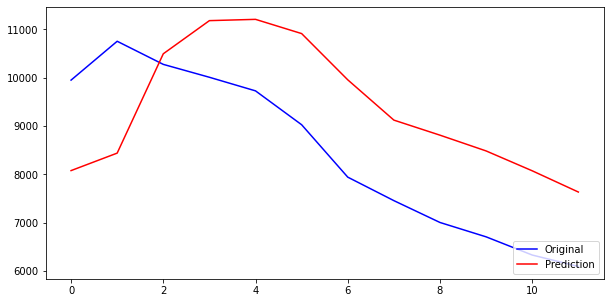

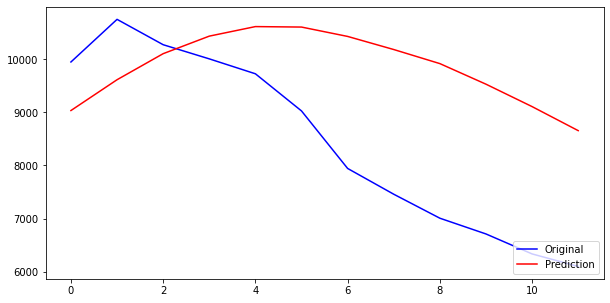

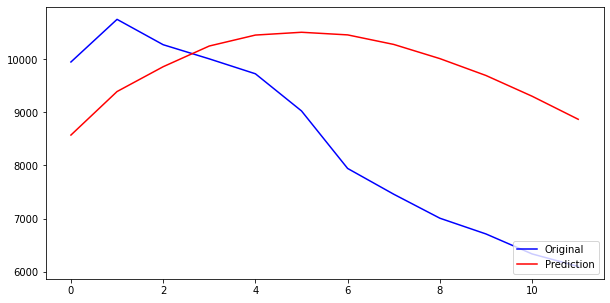

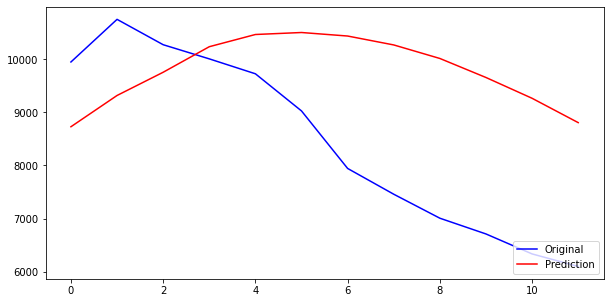

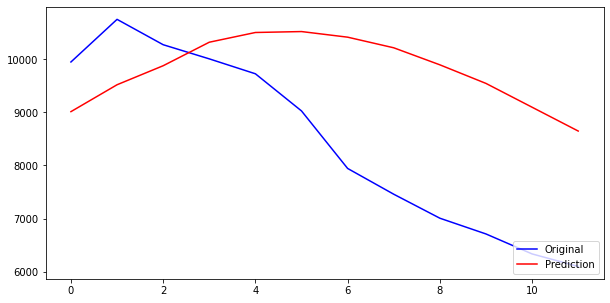

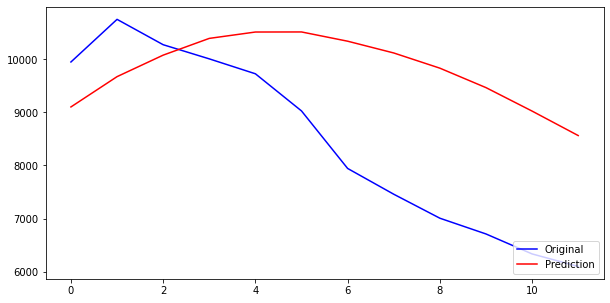

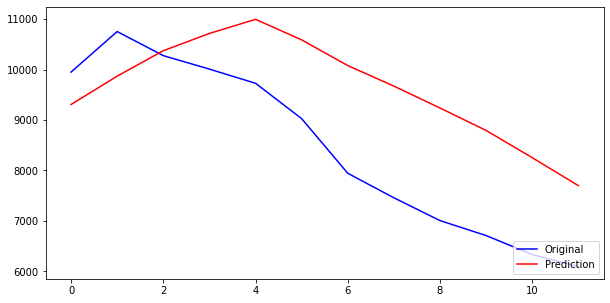

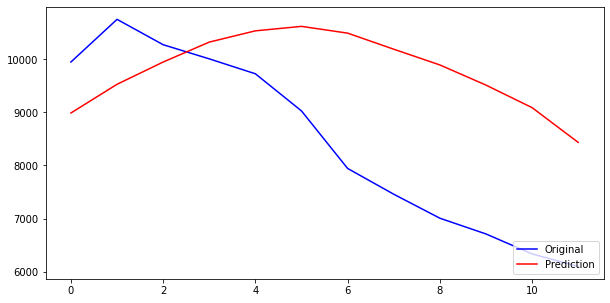

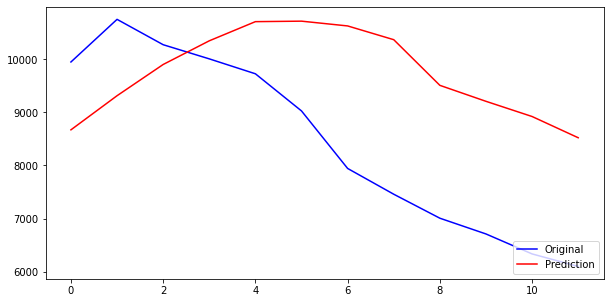

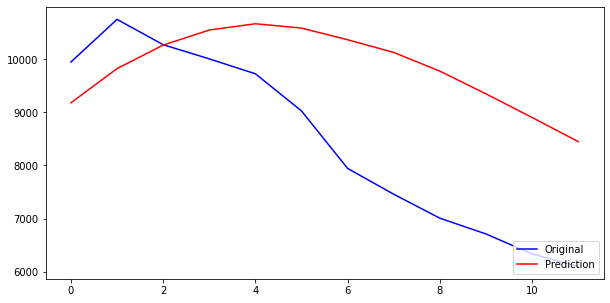

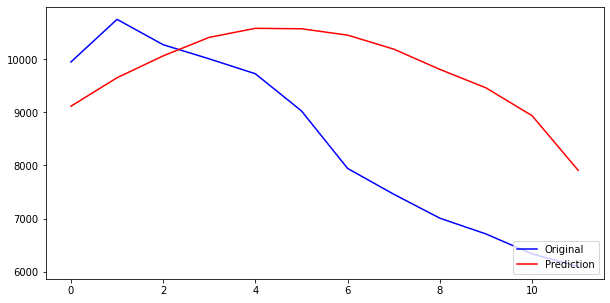

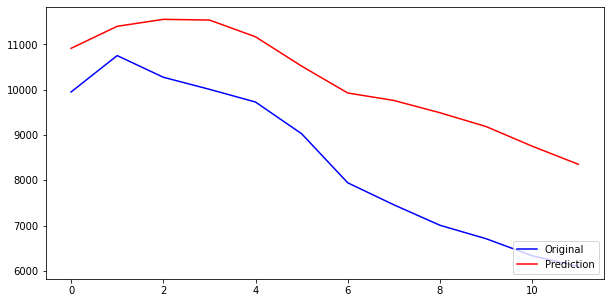

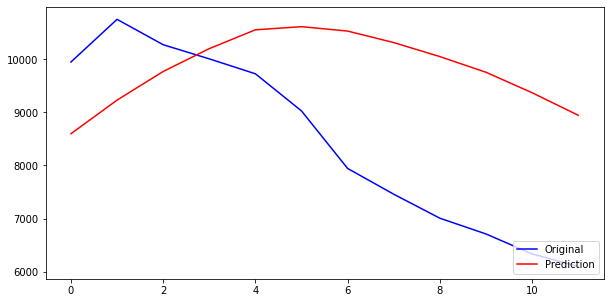

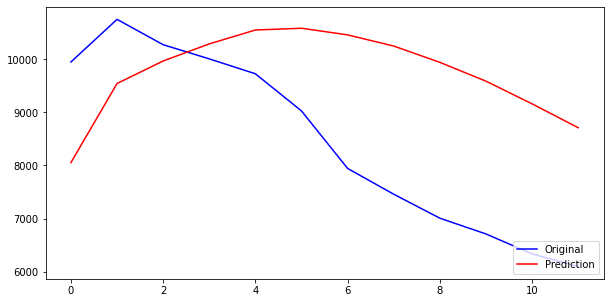

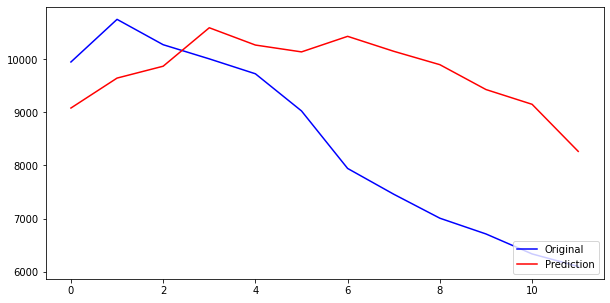

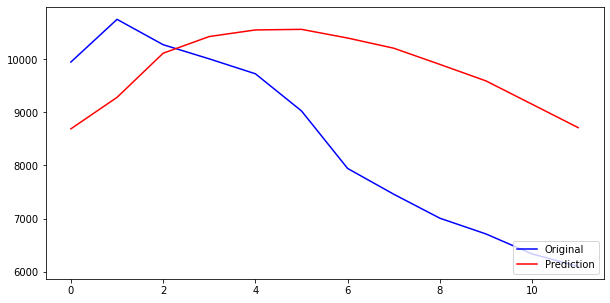

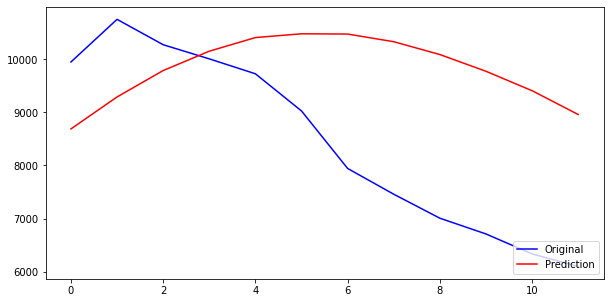

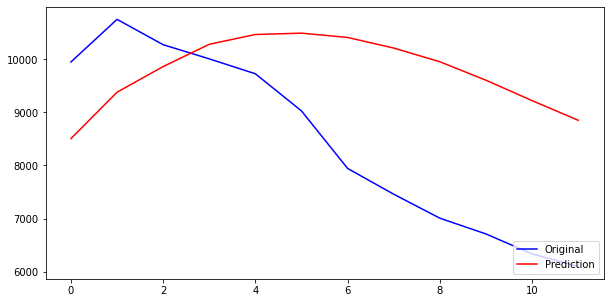

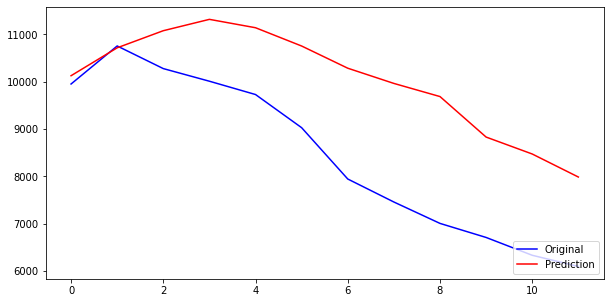

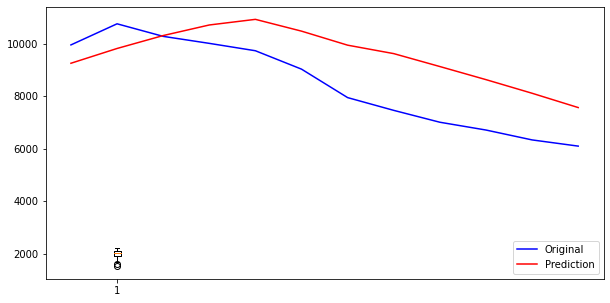

In [ ]:
# data split
n_test = 12

# define config 
# n seq: The number of subsequences within a sample.
# n steps: The number of time steps within each subsequence.
# n filters: The number of parallel filters.
# n kernel: The number of time steps considered in each read of the input sequence.
# n nodes: The number of LSTM units to use in the hidden layer.
# n epochs: The number of times to expose the model to the whole training dataset.
# n batch: The number of samples within an epoch after which the weights are updated.

config = [1, 12, 64, 3, 200, 350, 100]
# grid search
scores = repeat_evaluate(data2, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)